# ModernBERT + SBERT Dual Embedding Model Evaluation

This notebook evaluates a dual embedding model that combines ModernBERT and Sentence-BERT (SBERT) for the task of evidence detection. The model uses a combination of contextualized embeddings from ModernBERT and sentence embeddings from SBERT to predict whether a piece of evidence supports a given claim.

In [16]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.


In [17]:
%pip install seaborn matplotlib tqdm scikit-learn unidecode

Note: you may need to restart the kernel to use updated packages.


In [18]:
%pip install -U huggingface_hub transformers bitsandbytes peft sentence-transformers pandas

Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import torch
import pickle
import logging
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
from peft import PeftModel
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, classification_report, precision_recall_curve
import re
import unidecode
import string
import random

from huggingface_hub import hf_hub_download

import torch
import torch.nn as nn


# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Dataset and Model Architecture

We define custom dataset classes to handle the dual embedding approach and the model architecture that combines ModernBERT and SBERT embeddings.

In [20]:
class DualEmbeddingDataset(Dataset):
    """
    Dataset for dual embedding model that ensures all tensors are on CPU.
    """
    def __init__(self, features):
        """
        Initialize the dataset with preprocessed features.

        Args:
            features: Dictionary of feature tensors including input_ids,
                      attention_mask, sbert_embeddings, and labels
        """
        self.input_ids = features["input_ids"]
        self.attention_mask = features["attention_mask"]
        self.sbert_embeddings = features["sbert_embeddings"]
        self.labels = features["labels"] if "labels" in features else None

        # Ensure all tensors are on CPU
        if self.input_ids.is_cuda:
            self.input_ids = self.input_ids.cpu()
        if self.attention_mask.is_cuda:
            self.attention_mask = self.attention_mask.cpu()
        if self.sbert_embeddings.is_cuda:
            self.sbert_embeddings = self.sbert_embeddings.cpu()
        if self.labels is not None and self.labels.is_cuda:
            self.labels = self.labels.cpu()

        # Validate tensor shapes
        assert len(self.input_ids) == len(self.attention_mask) == len(self.sbert_embeddings), \
            "All feature tensors must have the same first dimension"

    def __len__(self):
        return len(self.labels) if self.labels is not None else len(self.input_ids)

    def __getitem__(self, idx):
        """
        Get a single example from the dataset.

        Args:
            idx: Index to retrieve

        Returns:
            Dictionary of tensors for the given index
        """
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "sbert_embeddings": self.sbert_embeddings[idx]
        }
        if self.labels is not None:
            item["labels"] = self.labels[idx]
        return item
    

In [21]:
# Define the DualEmbeddingModel class again for loading
class DualEmbeddingModel(nn.Module):
    def __init__(self, modernbert_model, sbert_dim=384, hidden_size=768, dropout_rate=0):
        super(DualEmbeddingModel, self).__init__()
        self.modernbert = modernbert_model
        
        # Get embedding dimensions
        self.modernbert_dim = modernbert_model.config.hidden_size  # 768 for ModernBERT-base
        self.sbert_dim = sbert_dim
        
        # Classifier with variable hidden size
        self.classifier = nn.Sequential(
            nn.Linear(self.modernbert_dim + self.sbert_dim, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1)
        )
    
    @property
    def device(self):
        return next(self.parameters()).device
    
    def forward(self, input_ids, attention_mask, sbert_embeddings, labels=None):
        # Ensure inputs are on the same device as the model parameters
        device = self.device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        sbert_embeddings = sbert_embeddings.to(device)
        
        # Get ModernBERT embedding for [CLS] token
        modernbert_outputs = self.modernbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        modernbert_embedding = modernbert_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        
        # Concatenate embeddings
        combined_embedding = torch.cat([modernbert_embedding, sbert_embeddings], dim=1)
        
        # Classify
        logits = self.classifier(combined_embedding).squeeze(-1)
        
        return logits

## Data Preprocessing

These functions prepare the text data for model input by cleaning and normalizing text and extracting features.

In [22]:
def clean_text(text):
    """
    Clean text by removing reference tags and normalizing whitespace.

    Args:
        text (str): The input text to clean.

    Returns:
        str: The cleaned text.
    """
    # Remove reference tags
    cleaned_text = re.sub(r"\[REF\]|\[REF|REF\]", "", text).strip()

    # Normalize text
    cleaned_text = unidecode.unidecode(cleaned_text)

    punctuations = re.escape(string.punctuation)  # escape special characters like [ ] ( ) etc.

    # Remove spaces between letter and punctuation
    cleaned_text = re.sub(r"([a-zA-Z])\s+([{}])".format(punctuations), r"\1\2", cleaned_text)
    # Remove spaces between punctuation and another punctuation
    cleaned_text = re.sub(r"([{}])\s+([{}])".format(punctuations, punctuations), r"\1\2", cleaned_text)

    # Remove extra whitespaces
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text

In [23]:
def prepare_dual_embedding_features(df, modernbert_tokenizer, sbert_model, max_length=8192, sbert_batch_size=64):
    """
    Prepare features for the dual embedding model, ensuring all tensors remain on CPU.

    Args:
        df: DataFrame with 'Claim', 'Evidence', and label columns
        modernbert_tokenizer: ModernBERT tokenizer
        sbert_model: Sentence-BERT model
        max_length: Maximum sequence length for tokenization
        sbert_batch_size: Batch size for SBERT encoding

    Returns:
        Dictionary of feature tensors with input_ids, attention_mask, sbert_embeddings, and labels
    """
    # Keep track of original SBERT device
    original_device = next(sbert_model.parameters()).device
    logger.info(f"Original SBERT device: {original_device}")

    # Prepare inputs
    texts_claim = df["Claim"].tolist()
    texts_evidence = df["Evidence"].tolist()

    # ModernBERT tokenization - keep on CPU
    logger.info("Tokenizing inputs for ModernBERT...")
    modernbert_features = modernbert_tokenizer(
        texts_claim,
        texts_evidence,
        padding=True,
        truncation="only_second",
        max_length=max_length,
        return_tensors="pt"
    )

    # Compute SBERT embeddings on GPU, then move back to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Computing SBERT embeddings on: {device}")

    # Temporarily move SBERT to computation device
    sbert_model = sbert_model.to(device)

    # Compute claim embeddings
    logger.info("Computing SBERT embeddings for claims (batched)...")
    claim_embeddings = sbert_model.encode(
        texts_claim,
        convert_to_tensor=True,
        batch_size=sbert_batch_size,
        show_progress_bar=True,
        device=device
    )

    # Move claim embeddings to CPU immediately
    claim_embeddings = claim_embeddings.cpu()

    # Compute evidence embeddings
    logger.info("Computing SBERT embeddings for evidence (batched)...")
    evidence_embeddings = sbert_model.encode(
        texts_evidence,
        convert_to_tensor=True,
        batch_size=sbert_batch_size,
        show_progress_bar=True,
        device=device
    )

    # Move evidence embeddings to CPU immediately
    evidence_embeddings = evidence_embeddings.cpu()

    # Return SBERT to original device
    sbert_model = sbert_model.to(original_device)

    # Combine claim and evidence embeddings on CPU
    logger.info("Combining embeddings...")
    combined_embeddings = []
    for claim_emb, evid_emb in tqdm(zip(claim_embeddings, evidence_embeddings),
                                  total=len(claim_embeddings),
                                  desc="Combining embeddings"):
        # Use average of the claim and evidence embeddings
        combined_emb = (claim_emb + evid_emb) / 2
        combined_embeddings.append(combined_emb)

    sbert_embeddings = torch.stack(combined_embeddings)

    # Prepare labels
    if "label" in df.columns:
        label_col = "label"
    elif "labels" in df.columns:
        label_col = "labels"
    else:
        raise ValueError("DataFrame must contain 'label' or 'labels' column")

    # Keep labels on CPU
    labels = torch.tensor(df[label_col].values, dtype=torch.float)

    # Final verification that all tensors are on CPU
    logger.info("Verifying all tensors are on CPU...")
    for key, tensor in modernbert_features.items():
        if tensor.is_cuda:
            logger.warning(f"{key} is on CUDA, moving to CPU")
            modernbert_features[key] = tensor.cpu()

    if sbert_embeddings.is_cuda:
        logger.warning("sbert_embeddings is on CUDA, moving to CPU")
        sbert_embeddings = sbert_embeddings.cpu()

    if labels.is_cuda:
        logger.warning("labels is on CUDA, moving to CPU")
        labels = labels.cpu()

    return {
        "input_ids": modernbert_features["input_ids"],
        "attention_mask": modernbert_features["attention_mask"],
        "sbert_embeddings": sbert_embeddings,
        "labels": labels
    }

## Model Loading Functions

These functions load the dual embedding model from a local directory or from the Hugging Face Hub.

In [24]:
def load_dual_embedding_model_from_hub(repo_id, device=None):
    """
    Load a DualEmbeddingModel from Hugging Face Hub.
    
    Args:
        repo_id: Hugging Face repository ID (e.g., "username/model-name")
        device: Device to load the model to
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load tokenizer from Hub
    tokenizer = AutoTokenizer.from_pretrained(repo_id, strip_accents=True)
    
    # Load SBERT model
    sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    
    # Set up quantization config
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_storage=torch.bfloat16
    )
    
    # Load base ModernBERT model
    base_model = AutoModel.from_pretrained(
        "answerdotai/ModernBERT-base",
        quantization_config=quant_config,
        device_map=device
    )
    
    # Load the PEFT adapters
    peft_model = PeftModel.from_pretrained(base_model, repo_id, inference_mode=True)
    
    # Create DualEmbeddingModel
    model = DualEmbeddingModel(peft_model)
    
    # Load classifier weights using huggingface_hub
    from huggingface_hub import hf_hub_download
    
    # Download classifier weights file
    classifier_path = hf_hub_download(repo_id=repo_id, filename="classifier_weights.pt")
    classifier_weights = torch.load(classifier_path, map_location=device, weights_only=True)
    model.classifier.load_state_dict(classifier_weights)
    
    # Load optimal threshold
    threshold_path = hf_hub_download(repo_id=repo_id, filename="optimal_threshold.txt")
    with open(threshold_path, "r") as f:
        threshold = float(f.read().strip())
    
    model.eval()
    return model, tokenizer, sbert_model, threshold


def load_dual_embedding_model_local(model_dir, device=None):
    """
    Load a DualEmbeddingModel from a local directory.
    
    Args:
        model_dir: Path to the local directory containing the model files
        device: Device to load the model to (default: use CUDA if available)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(f"Loading model from {model_dir} to {device}")
    
    # Load tokenizer from local directory
    tokenizer = AutoTokenizer.from_pretrained(model_dir, strip_accents=True)
    
    # Load SBERT model
    sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    
    # Set up quantization config
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_storage=torch.bfloat16
    )
    
    # Load base ModernBERT model
    base_model = AutoModel.from_pretrained(
        "answerdotai/ModernBERT-base",
        quantization_config=quant_config,
        device_map=device
    )
    
    # Load the PEFT adapters from local directory
    peft_model = PeftModel.from_pretrained(base_model, model_dir, inference_mode=True)
    
    # Create DualEmbeddingModel
    model = DualEmbeddingModel(peft_model)
    
    # Load classifier weights from local file
    classifier_weights_path = os.path.join(model_dir, "classifier_weights.pt")
    if os.path.exists(classifier_weights_path):
        classifier_weights = torch.load(classifier_weights_path, map_location=device, weights_only=True)
        model.classifier.load_state_dict(classifier_weights)
        print(f"Loaded classifier weights from {classifier_weights_path}")
    else:
        print(f"Warning: Classifier weights file not found at {classifier_weights_path}")
    
    # Load optimal threshold
    threshold_path = os.path.join(model_dir, "optimal_threshold.txt")
    threshold = 0.5  # Default threshold
    if os.path.exists(threshold_path):
        with open(threshold_path, "r") as f:
            threshold = float(f.read().strip())
        print(f"Loaded optimal threshold: {threshold}")
    else:
        print(f"Warning: Threshold file not found at {threshold_path}, using default: {threshold}")
    
    model.eval()
    return model, tokenizer, sbert_model, threshold


In [25]:
def find_optimal_threshold(y_true, y_pred):
    """
    Find the optimal threshold for classification based on F1 score.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted probabilities.

    Returns:
        float: Optimal threshold.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)

    f1_scores = np.divide(
        2 * (precisions * recalls),
        (precisions + recalls),
        out=np.zeros_like(precisions),
        where=(precisions + recalls) > 0
    )

    best_idx = np.argmax(f1_scores[:-1])
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    logger.info(f"Best threshold: {best_threshold:.4f} with F1: {best_f1:.4f}")

    return best_threshold

In [26]:
def calculate_best_threshold(model, dataloader, device=None):
    """
    Calculate the best threshold for the model using the validation set,
    converting logits to probabilities with sigmoid.

    Args:
        model: The trained model.
        dataloader: DataLoader for the validation set.
        device: Device to run the model on. If None, will use CUDA if available.

    Returns:
        float: Best threshold based on F1 score.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move model to the specified device
    model = model.to(device)
    
    all_labels = []
    all_probs = []  # We'll store probabilities, not logits

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating best threshold"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            sbert_embeddings = batch["sbert_embeddings"].to(device)
            labels = batch["labels"].to(device)

            # Get logits from model
            logits = model(input_ids, attention_mask, sbert_embeddings)
            
            # Convert logits to probabilities using sigmoid
            probs = torch.sigmoid(logits)
            
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all probabilities and labels
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Find the optimal threshold based on F1 score
    best_threshold = find_optimal_threshold(all_labels, all_probs)

    logger.info(f"Best threshold: {best_threshold:.4f}")
    return best_threshold

## Model Evaluation

These functions evaluate the model performance on a test dataset and calculate various metrics.

In [27]:
def evaluate_model(model_dir, test_df, batch_size=16, device=None):
    """
    Evaluate the saved DualEmbeddingModel on a test dataset.
    
    Args:
        model_dir (str): Directory containing the saved model and tokenizer.
        test_df (pd.DataFrame): Test dataframe with 'Claim', 'Evidence', and 'label' columns.
        batch_size (int): Batch size for evaluation.
        device (str, optional): Device to load the model to.
    
    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load the model
    model, tokenizer, sbert_model, threshold = load_dual_embedding_model_from_hub(model_dir, device)
    
    # Explicitly move the entire model to the specified device
    model = model.to(device)
    
    # Make sure model is in evaluation mode
    model.eval()
    
    # Preprocess the test dataset
    test_df["Claim"] = test_df["Claim"].apply(clean_text)
    test_df["Evidence"] = test_df["Evidence"].apply(clean_text)

    test_df["label"] = test_df["label"].astype(np.float16)

    # Prepare the test dataset
    test_features = prepare_dual_embedding_features(test_df, tokenizer, sbert_model)
    test_dataset = DualEmbeddingDataset(test_features)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Perform evaluation
    all_logits = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", disable=False):
            # Explicitly move batch data to the same device as the model
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            sbert_embeddings = batch["sbert_embeddings"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids, attention_mask, sbert_embeddings)
            
            # Move results back to CPU for metric calculation
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all batches
    all_logits = torch.cat(all_logits, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    
    # Apply sigmoid to convert logits to probabilities
    probabilities = torch.sigmoid(torch.tensor(all_logits)).numpy()
    
    # Make predictions using the optimal threshold
    predictions = (probabilities > threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predictions, average='macro')
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, predictions, average='weighted')
    mcc = matthews_corrcoef(all_labels, predictions)


    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, predictions, target_names=["0", "1"], digits=6))

    # Print confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title("Confusion Matrix for ModernBERT + SBERT")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    
    # Print evaluation results
    print(f"Evaluation Results (threshold={threshold:.4f}):")
    print(f"  Accuracy: {accuracy:.6f}")
    print(f"  Precision (macro): {precision:.6f}")
    print(f"  Recall (macro): {recall:.6f}")
    print(f"  F1 Score (macro): {f1:.6f}")
    print(f"  Precision (weighted): {precision_macro:.6f}")
    print(f"  Recall (weighted): {recall_macro:.6f}")
    print(f"  F1 Score (weighted): {f1_macro:.6f}")
    print(f"  MCC: {mcc:.6f}")
    
    # Return metrics
    return {
        "threshold": threshold,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "precision_w": precision_macro,
        "recall_w": recall_macro,
        "f1_w": f1_macro,
        "mcc": mcc
    }

In [28]:
def predict_model(model_dir, test_df, batch_size=64, device=None):
    """
    Use the saved DualEmbeddingModel to make predictions on a batch of claim-evidence pairs.
    
    Args:
        model_dir (str): Directory containing the saved model and tokenizer.
        test_df (pd.DataFrame): Test dataframe with 'Claim' and 'Evidence' columns.
        batch_size (int): Batch size for prediction.
        device (str, optional): Device to load the model to.
    
    Returns:
        pd.DataFrame: Original dataframe with 'prediction' and 'probability' columns added.
    """
    # Load the model
    model, tokenizer, sbert_model, threshold = load_dual_embedding_model_from_hub(model_dir, device=device)

    # Explicitly move the entire model to the specified device
    model = model.to(device)

    # Make sure model is in evaluation mode
    model.eval()

    # Preprocess the test dataset
    test_df["Claim"] = test_df["Claim"].apply(clean_text)
    test_df["Evidence"] = test_df["Evidence"].apply(clean_text)

    test_df["label"] = test_df["label"].astype(np.float16)
    
    # Prepare the test dataset
    test_features = prepare_dual_embedding_features(test_df, tokenizer, sbert_model)
    test_dataset = DualEmbeddingDataset(test_features)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Perform predictions
    all_logits = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting", disable=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            sbert_embeddings = batch["sbert_embeddings"].to(device)
            
            logits = model(input_ids, attention_mask, sbert_embeddings)
            all_logits.append(logits.cpu())
    
    # Concatenate all batches
    all_logits = torch.cat(all_logits, dim=0).numpy()
    
    # Convert logits to probabilities with sigmoid
    probabilities = torch.sigmoid(torch.tensor(all_logits)).numpy()
    
    # Make predictions using the optimal threshold
    predictions = (probabilities > threshold).astype(int)
    
    # Add predictions and probabilities to the dataframe
    result_df = test_df.copy()
    result_df["prediction"] = predictions
    result_df["probability"] = probabilities
    
    return result_df

In [ ]:
DATASET_DIR = "training_data/ED"

test_df = pd.read_csv(os.path.join(DATASET_DIR, "dev.csv"))

## Inference and Performance Analysis

Here we load the model and run inference on the dev set to analyze its performance.

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 93/93 [01:46<00:00,  1.14s/it]


Classification Report:
              precision    recall  f1-score   support

           0   0.932713  0.889407  0.910546      4286
           1   0.742251  0.832317  0.784708      1640

    accuracy                       0.873608      5926
   macro avg   0.837482  0.860862  0.847627      5926
weighted avg   0.880004  0.873608  0.875721      5926



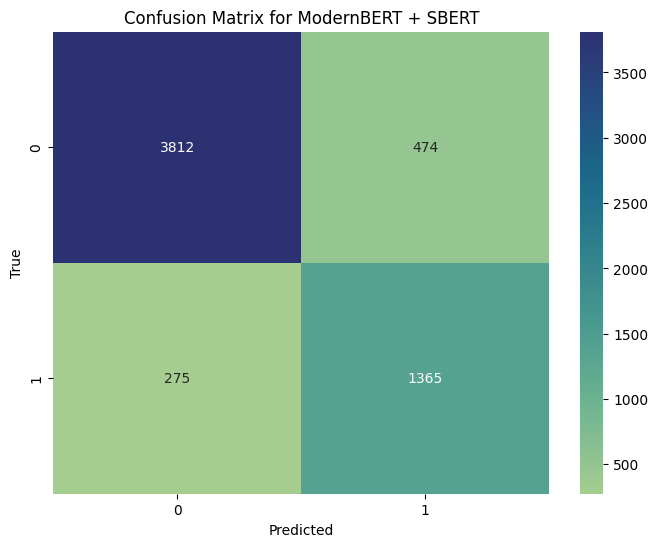

Evaluation Results (threshold=0.5433):
  Accuracy: 0.873608
  Precision (macro): 0.837482
  Recall (macro): 0.860862
  F1 Score (macro): 0.847627
  Precision (weighted): 0.880004
  Recall (weighted): 0.873608
  F1 Score (weighted): 0.875721
  MCC: 0.697953


In [30]:
# Load the model directory
model_dir = "ddosdub/DualEncoderModernBERT"

# Evaluate the model
metrics = evaluate_model(model_dir, test_df, batch_size=64, device="cuda" if torch.cuda.is_available() else "cpu")

In [31]:
predict_df = predict_model(model_dir, test_df, batch_size=64, device="cuda" if torch.cuda.is_available() else "cpu")

predict_df.head()

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Predicting: 100%|██████████| 93/93 [01:46<00:00,  1.14s/it]


,Claim,Evidence,label,prediction,probability
0,Democracy should be done away with.,"Amartya Sen, an Indian economist and Nobel lau...",0.0,0,0.467568
1,Polygamy should be made legal.,The Supreme Court's unanimous decision in Reyn...,1.0,1,0.997100
2,Hunting should be banned,In total it is estimated that Ceausescu receiv...,0.0,0,0.001340
3,Television should be given up.,Barbera mentioned that they had to either adju...,0.0,0,0.003276
4,Abortions ought to be prohibited.,According to a poll conducted by Angus Reid St...,1.0,1,0.996988


In [32]:
# get prediction column from the predict_df
predictions = predict_df["prediction"]

# convert to csv
predictions.to_csv("predictions.csv", index=False)

def create_file_for_submission(predictions: pd.DataFrame, ext: str = "predict"):
    predictions.to_csv(f"predictions.csv.{ext}", index=False)

    # zip the file
    import zipfile
    with zipfile.ZipFile("predictions.zip", "w") as zf:
        zf.write(f"predictions.csv.{ext}")

create_file_for_submission(pd.read_csv("predictions.csv"))